- Data Structure, p.90
- Travel concepts, p.372


- How do I deal with the big shift in how NHTS data is delivered with NHTS NextGen? ATF is active transportation and ferries; should I just combine those into a single category in the 2011-2017 data?

In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# https://stackoverflow.com/questions/34478398/import-local-function-
# from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import local_module as local

# Data Caveats

- We use the WTTRDFIN column for trip estimates. This column has a somewhat complex definition. That definition changes in the 2020 data (?)

In [2]:
# potentiall relevant columns

DAY_cols = [
    "TRPTRANS", # transportation mode on travel day trip
    # travel day trip weight for persons in households where at least 
    # 50 percent of household members 18 and over completed a person interview
    "WTTRDFIN" 
]

HH_cols = [
    "HHNUMBIK", # number of full size bicycles in household
    "HHSTFIPS" # FIPS state code for household
]

PER_cols = [
    "NBIKETRP", # number of bike trips in the last week
    "NWALKTRP", # number of walk trips in the last week
    "DTNOWALK", # lack of walkways or sidewalks
    "WRKTRANS" # transportation mode to work last week
]

# 2001 - 2017

In [3]:
# list of NHTS years
years = [2001, 2009, 2017]

# URLs to access NHTS data 2001-2017
url_dict = {
    2001: "https://nhts.ornl.gov/2001/download/Ascii.zip",
    2009: "https://nhts.ornl.gov/2009/download/Ascii.zip",
    2017: "https://nhts.ornl.gov/assets/2016/download/csv.zip"
}

# filenames for trip 
file_dict = {
    2001: "DAYPUB.csv",
    2009: "Ascii/DAYV2PUB.CSV",
    2017: "trippub.csv"
}

# dictionaries for the TRPTRANS column

# 2001
# User Manual B-136 / PDF p.267
TRPTRANS_01_dict = {
    -1: "Appropriate Skip",
    -7: "Refused",
    -8: "Don't Know",
    -9: "Not Ascertained",
    1: "Car",
    2: "Van",
    3: "SUV",
    4: "Pickup truck",
    5: "Other truck",
    6: "RV",
    7: "Motorcycle",
    8: "Commercial/charter airplane",
    9: "Private/corporate airplane",
    10: "Local public transit bus",
    11: "Commuter bus",
    12: "School bus",
    13: "Charter/tour bus",
    14: "City to city bus",
    15: "Amtrack/inter city train",
    16: "Commuter train",
    17: "Subway/elevated rail",
    18: "Street car/trolley",
    19: "Ship/cruise",
    20: "Passenger line/ferry",
    21: "Sailboat/motorboat/Yacht",
    22: "Taxicab",
    23: "Limousine",
    24: "Hotel/airport shuttle",
    25: "Bicycle", # active transportation
    26: "Walk", # active transportation
    91: "Other"
}

# 2009
# Codebook B-83 / PDF p.83
TRPTRANS_09_dict = {
    -1: "Appropriate skip",
    -7: "Refused", 
    -8: "Don't know", 
    -9: "Not ascertained",
    1: "Car",
    2: "Van", 
    3: "SUV", 
    4: "Pickup truck",
    5: "Other truck",
    6: "RV",
    7: "Motorcycle",
    8: "Light electric veh (golf cart)",
    9: "Local public bus",
    10: "Commuter bus",
    11: "School bus",
    12: "Charter/tour bus",
    13: "City to city bus",
    14: "Shuttle bus",
    15: "Amtrak/inter city train",
    16: "Commuter train",
    17: "Subway/elevated train",
    18: "Street car/trolley",
    19: "Taxicab",
    20: "Ferry",
    21: "Airplane",
    22: "Bicycle", # active transportation
    23: "Walk", # active transportation
    24: "Special transit-people w/disabilities",
    97: "Other"                                                                                
}

# 2017
# Codebook PDF p.100
TRPTRANS_17_dict = {
    -9: "Not ascertained",
    -8: "I don't know", 
    -7: "prefer not to answer",
    1: "Walk", # active transportation
    2: "Bicycle", # active transportation
    3: "Car",
    4: "SUV",
    5: "Van",
    6: "Pickup truck",
    7: "Golf cart / Segway",
    8: "Motorcycle / Moped",
    9: "RV (motor home, ATV, snowmobile)",
    10: "School bus",
    11: "Public or commuter bus",
    12: "Paratransit / Dial-a-ride",
    13: "Private / Charter / Tour / Shuttle bus",
    14: "City-to-city bus (Greyhound, Megabus)",
    15: "Amtrak / Commuter rail",
    16: "Subway / elevated / light rail / street car",
    17: "Taxi / limo (including Uber / Lyft)",
    18: "Rental car (Including Zipcar / Car2Go)",
    19: "Airplane",
    20: "Boat / ferry / water taxi", 
    97: "Something Else"
}

# nested TRPTRANS dictsionaries keyed by year
nested = {
    2001: TRPTRANS_01_dict,
    2009: TRPTRANS_09_dict,
    2017: TRPTRANS_17_dict
}

In [4]:
# calculate trips by mode for each year of NHTS

trips = pd.DataFrame() # initialize dataframe

for year in years:
    
    # access url and read trips CSV into dataframe
    nhts = local.fetch_multi_csv_zip_from_url(
        url= url_dict.get(year), 
        filenames=[file_dict.get(year)],
        low_memory=False # deal with multiple dtypes in one column
    )
    
    # replace TRPTRANS column values
    nhts["TRPTRANS"].replace(nested.get(year), inplace=True)
    
    # group total valid trips by mode according to directions in Travel Concepts
    count = nhts.groupby("TRPTRANS")["WTTRDFIN"].sum().reset_index().sort_values("WTTRDFIN", ascending=False)
    
    # rename columns
    count.rename(
        columns={"TRPTRANS": "MODE", "WTTRDFIN": str(year)}, 
        inplace=True
    )

    # tidy
    count = count.melt(
        id_vars="MODE",
        value_vars=str(year),
        var_name="YEAR", 
        value_name= "TRIPS"
    )
    
    # combine into single dataframe
    trips = pd.concat([trips, count])
    
    print(str(year) + " complete.")

2001 complete.
2009 complete.
2017 complete.


In [5]:
# resetting and dropping non-unique index
# from building dataframe
trips.reset_index(inplace=True)
trips.drop(columns="index", inplace=True)

In [6]:
# calculate total trips for the year
tot_trips = trips.groupby(['YEAR'])['TRIPS'].agg('sum') # series
tot_trips_dict = tot_trips.to_dict() # create a dictionary to lookup total trips by year

# calculate percentage of total trips for each mode
trips["P_TRIPS"] = (trips["TRIPS"] / trips["YEAR"].map(tot_trips_dict))
trips

,MODE,YEAR,TRIPS,P_TRIPS
0,Car,2001,2.003210e+11,4.918721e-01
1,Van,2001,5.127403e+10,1.258992e-01
2,SUV,2001,5.068996e+10,1.244651e-01
3,Pickup truck,2001,4.684039e+10,1.150128e-01
4,Walk,2001,3.536637e+10,8.683925e-02
...,...,...,...,...
79,Boat / ferry / water taxi,2017,1.756186e+08,4.731717e-04
80,"City-to-city bus (Greyhound, Megabus)",2017,6.854286e+07,1.846760e-04
81,I don't know,2017,6.918375e+06,1.864027e-05
82,prefer not to answer,2017,2.482589e+05,6.688873e-07


In [7]:
# cut to only walk and bicycle modes
trips = trips.loc[(trips["MODE"] =="Walk") | (trips["MODE"] == "Bicycle")]

<AxesSubplot:xlabel='YEAR', ylabel='TRIPS'>

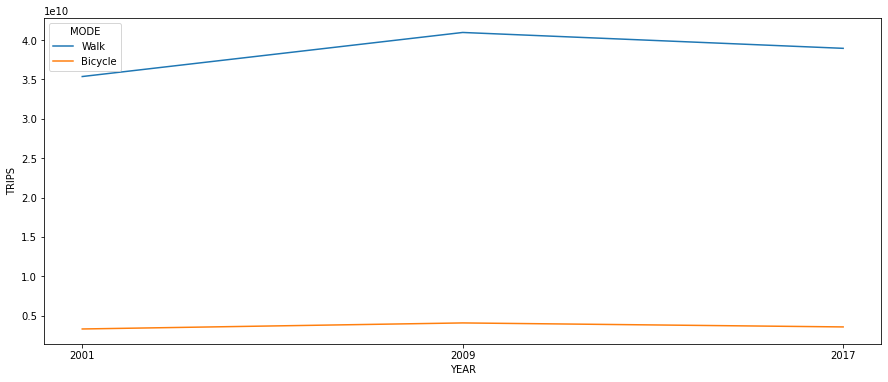

In [12]:
# plot absolute trips over full year range
f, ax = plt.subplots(1, figsize=(15,6))

sns.lineplot(
    data=trips, 
    x="YEAR", 
    y="TRIPS", 
    hue="MODE",
    ax=ax
)

<AxesSubplot:xlabel='YEAR', ylabel='P_TRIPS'>

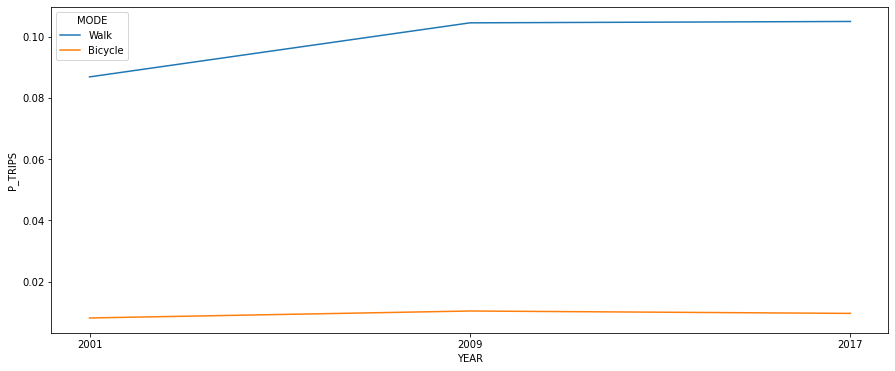

In [11]:
# plot absolute trips over full year range
f, ax = plt.subplots(1, figsize=(15,6))

sns.lineplot(
    data=trips, 
    x="YEAR", 
    y="P_TRIPS", 
    hue="MODE",
    ax=ax
)

# 2020